### Importing libraries

In [32]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import linear_model
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

# Question 1: Propensity score matching

## Loading the data

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

The dataset contains 614 observations.
We observe that the categorical variables are encoded using dummy varibales, i.e. binary variables. We are going to stick with this encoding as it is advantegous for the regression task that we are going to perform later. 



In [2]:
lalonde_data = pd.read_csv("lalonde.csv")
lalonde_data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [3]:
len(lalonde_data)

614

## 1. A naive analysis

To begin with, we compare the distribution of the outcome variable (re78) between the two groups in a naive way. This means that we do not consider relationships between the outcome variable and other available features, and just focus on the differences (possibly) induced by participating in the job training program.

We compare the distributions based on:

1. Boxplot diagrams
2. Histograms
3. QQ plots
4. Summary statistics
5. Mann-Whitney-U test

For these steps of the analysis we define the following functions:

In [4]:
treat = {0: 'treated', 1: 'control'}

def draw_box(df, col):
    """Draw a box plot for the values of the specified column for each of the two groups"""
    df.boxplot(by='treat', column=col, figsize = [10, 7], grid=False)

def draw_hist(df, col):
    """Draw histograms and kernel density estimation plots for the specified column.
    Two plots are created for the two groups but displayed in two overlapping layers for comparison.
    """
    fig_hist, axs_hist = plt.subplots(nrows=2)
    df.groupby("treat")[col].plot(kind='kde', ax=axs_hist[1])
    axs_hist[1].set_xlabel(col)
    groups = df.groupby("treat")[col]
    for k, v in groups:
        v.hist(label=treat[k], alpha=.75, ax=axs_hist[0], bins=15, range=[df[col].min(), df[col].max()], figsize = [10, 7])
    axs_hist[0].legend()
    axs_hist[0].set_ylabel('number of participants')
    

def draw_qqs(df, col):
    """Draw a QQ plot for both groups to find out more about the distribution of the data.
    NB: A comparison to a normal distribution with fitted parameters is performed."""
    fig_qq, axs_qq = plt.subplots(nrows=2, figsize=(10, 20))
    stats.probplot(df[df.treat == 0][col], dist="norm", plot=axs_qq[0])
    axs_qq[0].set_title('Control Group')
    stats.probplot(df[df.treat == 1][col], dist="norm", plot=axs_qq[1])
    axs_qq[1].set_title('Treatment Group')
    plt.show()
    
def get_summary(df, col):
    """Print summary statistics for both groups."""
    print('Control group')
    print('================================================')
    print(round(df[df.treat == 0][col].describe(), 2))
    print('================================================')
    print()
    print('Treatment group')
    print('================================================')
    print(round(df[df.treat == 1][col].describe(), 2))

def test(df, col):
    """Perform Mann-Whitney-U test and pretty print result.""" 
    s, p = stats.mannwhitneyu(df[df.treat == 0][col], df[df.treat == 1][col])
    print('Mann-Whitney-U test:')
    print('================================================')
    print('p-value: ', round(p, 4))
    print('test statistic: ', round(s, 1))

Furthermore, we define a function that invokes all the functions for numerical features and displays the output in a structured way.

In [5]:
def analyse_numeric(df, col):    
    """Perform analysis for a numerical feature and pretty print result."""
    print('=================================================================================')
    print('                                  ', col)
    print('=================================================================================')
    draw_box(df, col)
    draw_hist(df, col)
    draw_qqs(df, col)
    print()
    get_summary(df, col)
    print()
    test(df, col)
    print()
    print()

Let us now analyse the distribution of the real earnings in 1978 in the two groups.

                                   re78


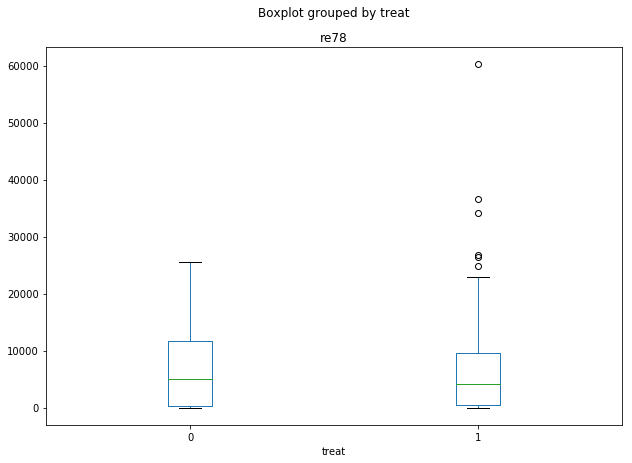

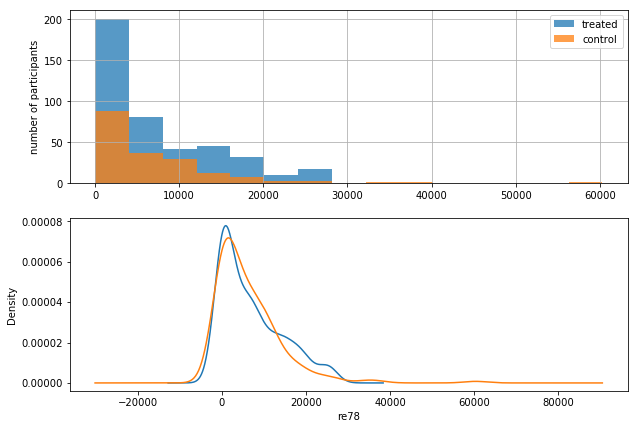

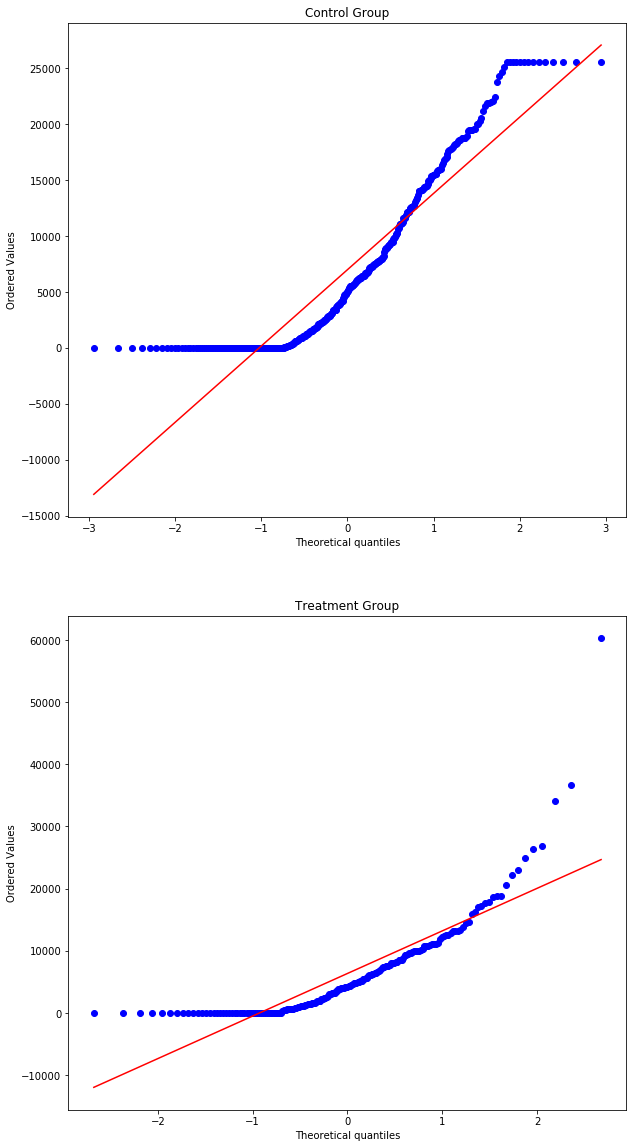


Control group
count      429.00
mean      6984.17
std       7294.16
min          0.00
25%        220.18
50%       4975.50
75%      11688.82
max      25564.67
Name: re78, dtype: float64

Treatment group
count      185.00
mean      6349.14
std       7867.40
min          0.00
25%        485.23
50%       4232.31
75%       9643.00
max      60307.93
Name: re78, dtype: float64

Mann-Whitney-U test:
p-value:  0.1409
test statistic:  37525.0




In [6]:
analyse_numeric(lalonde_data, 're78')

### **(Naive) Conclusions:** .... TODO...

## 2. A closer look at the data

In order to get a better understanding of whether our naive analysis was appropriate, we now compare the distributions of the other covariates within the treatment groups. To begin with, we interpret the numerical features in using the same strategy as in Part 1.

### Analysis of quantitative features

                                   age


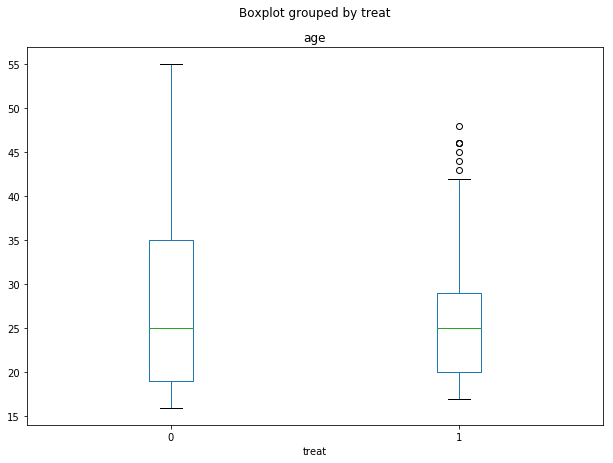

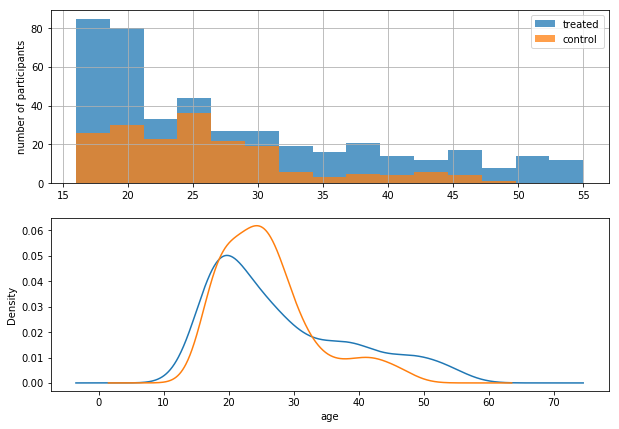

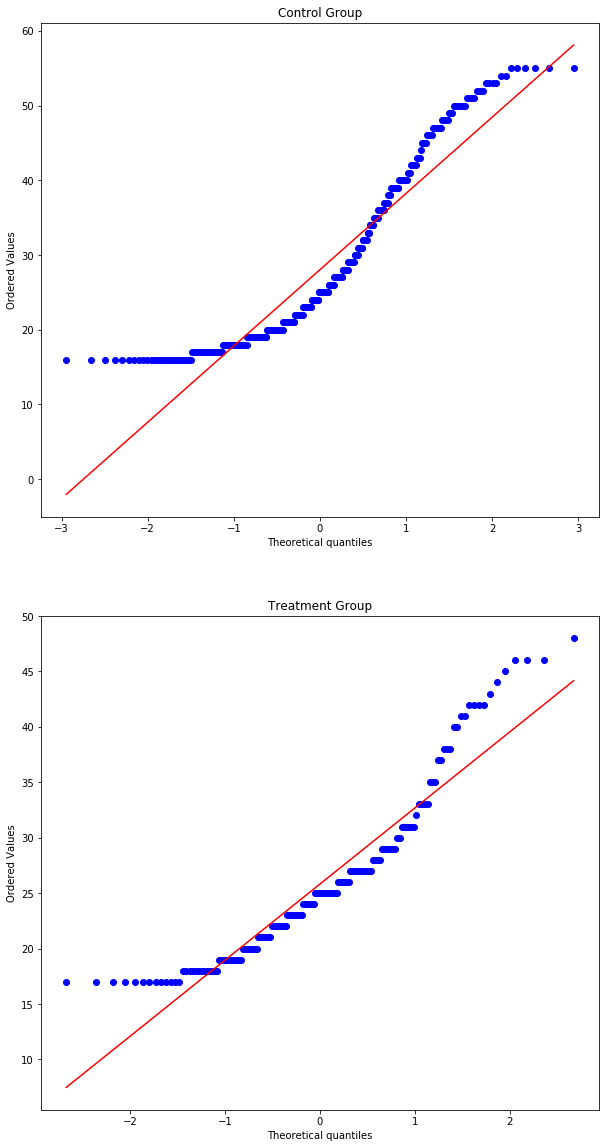


Control group
count    429.00
mean      28.03
std       10.79
min       16.00
25%       19.00
50%       25.00
75%       35.00
max       55.00
Name: age, dtype: float64

Treatment group
count    185.00
mean      25.82
std        7.16
min       17.00
25%       20.00
50%       25.00
75%       29.00
max       48.00
Name: age, dtype: float64

Mann-Whitney-U test:
p-value:  0.2598
test statistic:  38384.5




In [7]:
analyse_numeric(lalonde_data, 'age')

                                   educ


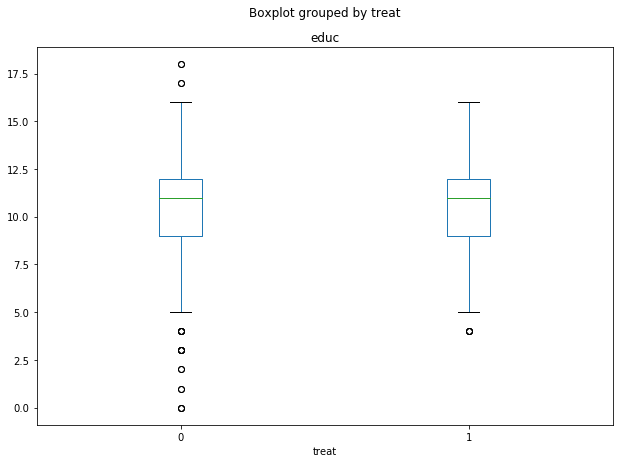

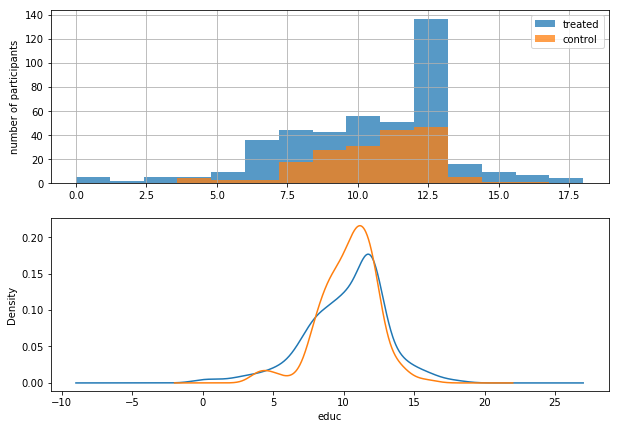

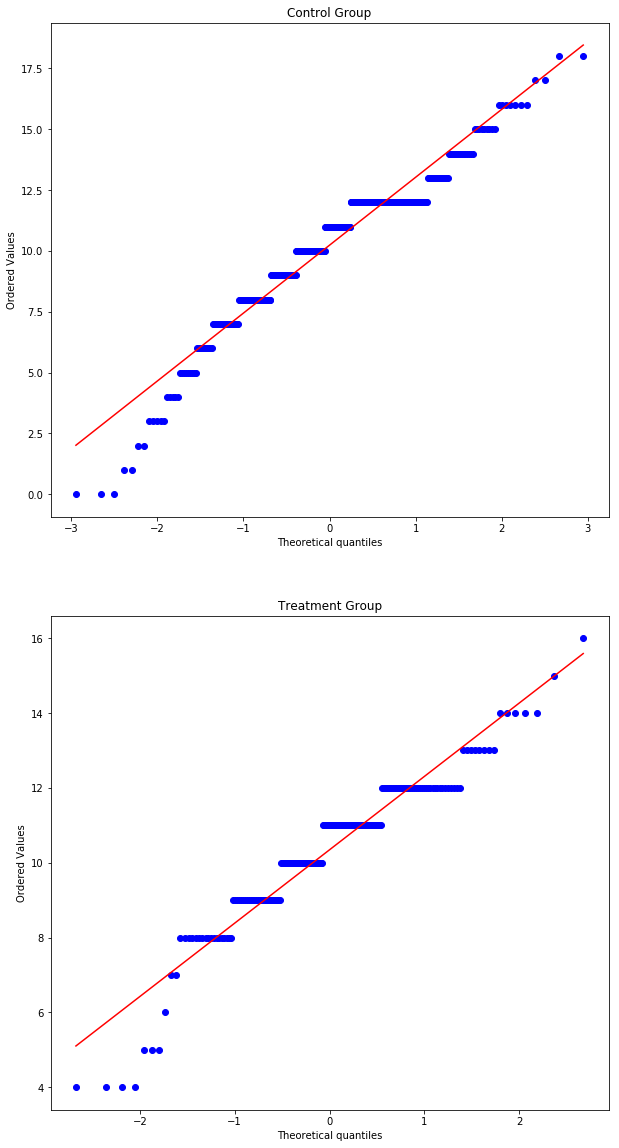


Control group
count    429.00
mean      10.24
std        2.86
min        0.00
25%        9.00
50%       11.00
75%       12.00
max       18.00
Name: educ, dtype: float64

Treatment group
count    185.00
mean      10.35
std        2.01
min        4.00
25%        9.00
50%       11.00
75%       12.00
max       16.00
Name: educ, dtype: float64

Mann-Whitney-U test:
p-value:  0.396
test statistic:  39157.0




In [8]:
analyse_numeric(lalonde_data, 'educ')

                                   re74


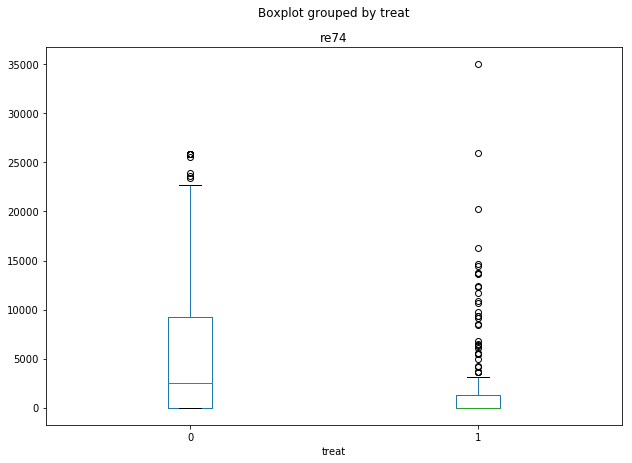

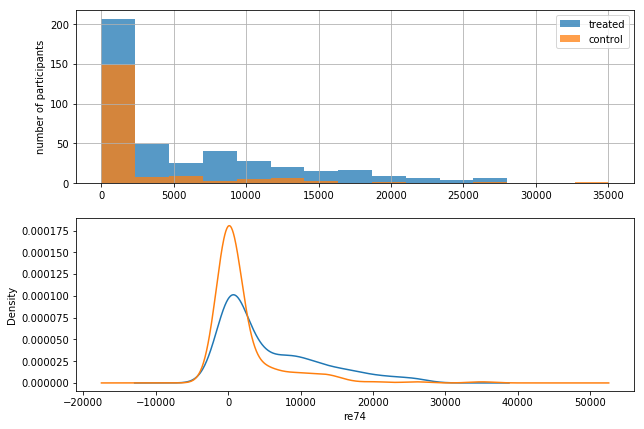

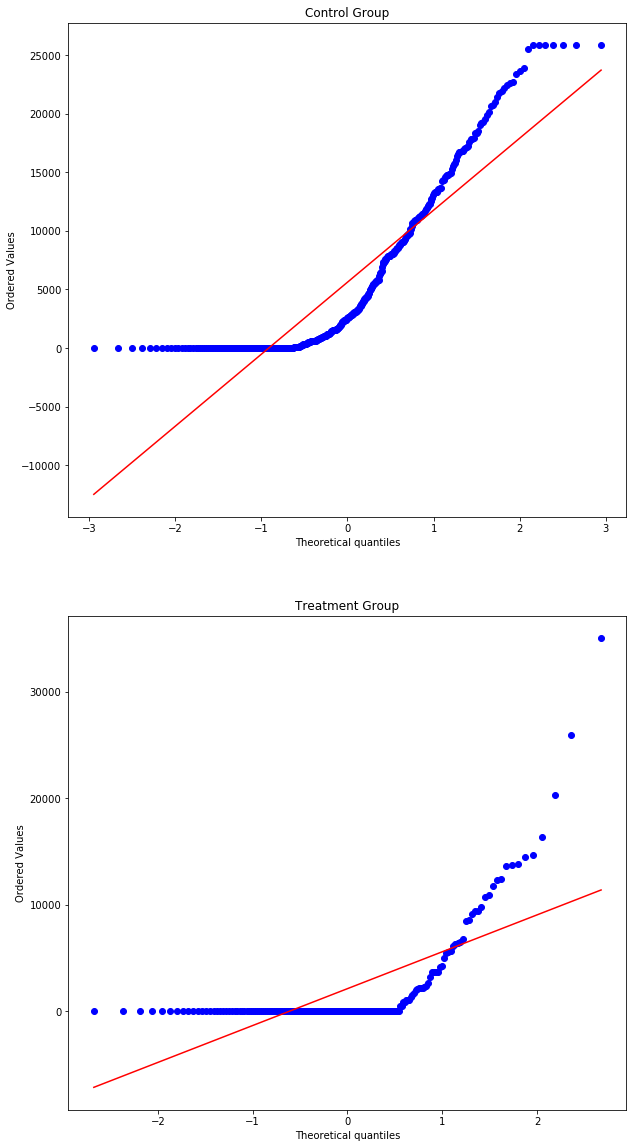


Control group
count      429.00
mean      5619.24
std       6788.75
min          0.00
25%          0.00
50%       2547.05
75%       9277.13
max      25862.32
Name: re74, dtype: float64

Treatment group
count      185.00
mean      2095.57
std       4886.62
min          0.00
25%          0.00
50%          0.00
75%       1291.47
max      35040.07
Name: re74, dtype: float64

Mann-Whitney-U test:
p-value:  0.0
test statistic:  21928.0




In [9]:
analyse_numeric(lalonde_data, 're74')

                                   re75


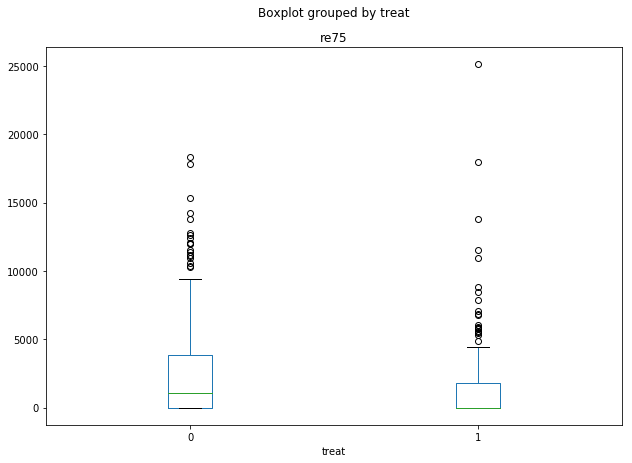

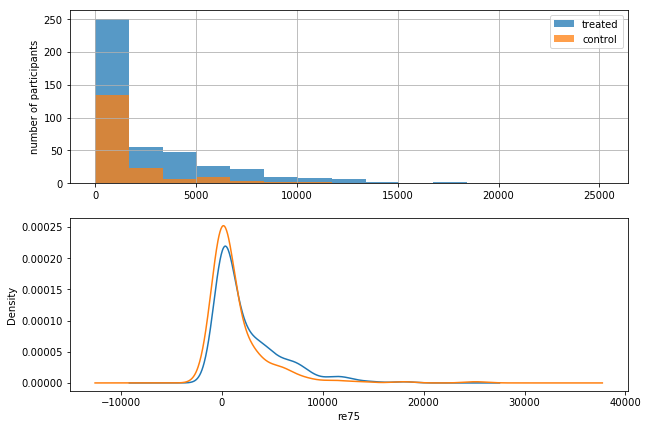

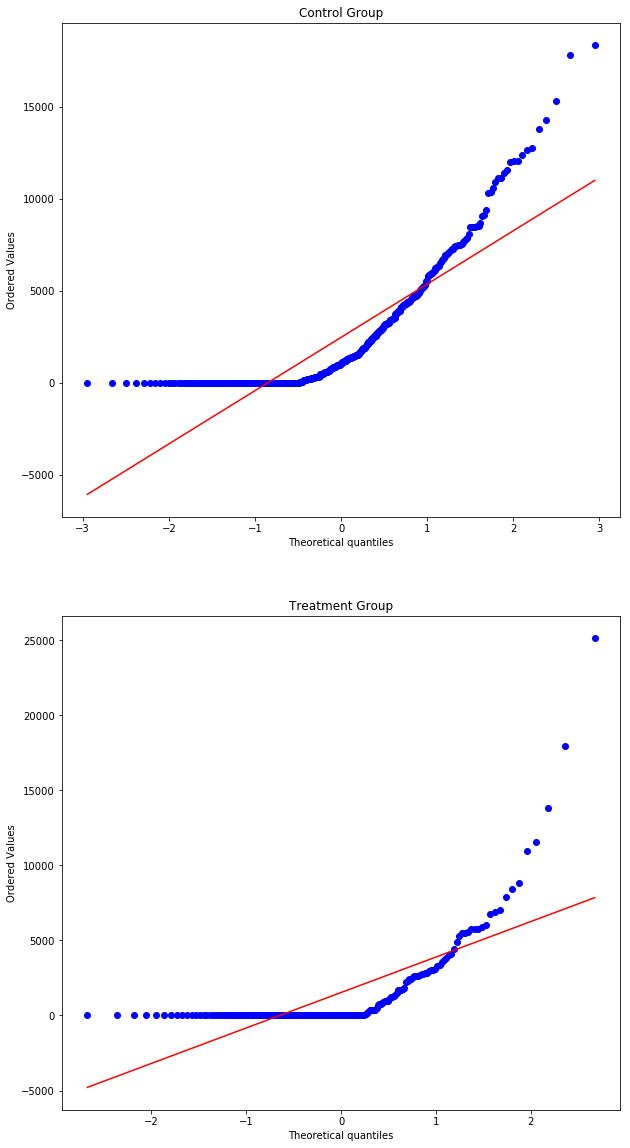


Control group
count      429.00
mean      2466.48
std       3292.00
min          0.00
25%          0.00
50%       1086.73
75%       3881.42
max      18347.23
Name: re75, dtype: float64

Treatment group
count      185.00
mean      1532.06
std       3219.25
min          0.00
25%          0.00
50%          0.00
75%       1817.28
max      25142.24
Name: re75, dtype: float64

Mann-Whitney-U test:
p-value:  0.0
test statistic:  28612.0




In [10]:
analyse_numeric(lalonde_data, 're75')

#### **Interpretation:** .... TODO...

### Analysis of categorical features

It remains to take a closer look at the categorical covariates. As the methods used above are not appropriate for categorical variables, we need to define new functions for the analysis. For example, there is no point in drawing histograms for categrical variables, the thing to use here are bar plots.

In [11]:
def draw_bar(df, col):
    '''Draw a bar plot of the number of values in each category for the two groups'''
    df_grouped = df.groupby(['treat', col])[col].count()
    df_grouped = df_grouped.unstack()
    pl = df_grouped.plot(kind='bar', figsize=[5,5], rot=0)
    pl.set_title(col)
    pl.set_ylabel('number of participants')
    pl.set_xlabel('group')
    plt.show()


For the race feature some preprocessing is needed in order to be able to draw a meaningful bar plot. Especially, the data frame does not contain a column for white people. We assume that individuals are white in case they are neither black nor hispanic.

In [41]:
def plot_race(df):
    '''Draw a bar plot for the race feature.'''
    df['white'] = (~(df['black'].astype(bool) | df['hispan'].astype(bool))).astype(int)
    race = df[['white', 'black', 'hispan']].stack()
    del df['white']
    race = pd.Series(pd.Categorical(race[race!=0].index.get_level_values(1)))
    race_group = pd.concat([df.treat, race], axis=1, keys=['treat', 'race'])
    draw_bar(race_group, 'race')

For the significance test we use Chi-square test of independence. Analysing the relationship between race and group mem

In [42]:
def test_chisq(df, col, table):
    '''Perform chi sqauare test'''
    print('Chi-square test')
    print('================================================')
    #perform test
    s, p, _, _ = stats.chi2_contingency(table)
    print('p-value: ', round(p, 4))
    print('test statistic: ', round(s, 1))

In [43]:
def analyse_categoric(df, col):    
    """Perform analysis for a categorical feature and pretty print result."""
    print('=================================================================================')
    print('                                  ', col)
    print('=================================================================================')
    draw_bar(df, col)
    print()
    get_summary(df, col)
    print()
    
    #compute contingency table and perform test
    df['neg'] = df[col].apply(lambda x: 1-x)
    table = df.groupby(df.treat)[col, 'neg'].sum()
    del df['neg']
    test_chisq(df, col, table)
    
    print()
    print()

In [44]:
def analyse_race(df):    
    """Perform analysis for a categorical feature and pretty print result."""
    print('=================================================================================')
    print('                                  race')
    print('=================================================================================')
    plot_race(df)
    print()
    print()
    
    #compute contingency table and perform test
    df['white'] = (~(df['black'].astype(bool) | df['hispan'].astype(bool))).astype(int)
    table = df.groupby(df.treat)['white', 'black', 'hispan'].sum()
    del df['white']
    
    test_chisq(df, col, table)

Now we can use those functions for our analysis:

                                   married


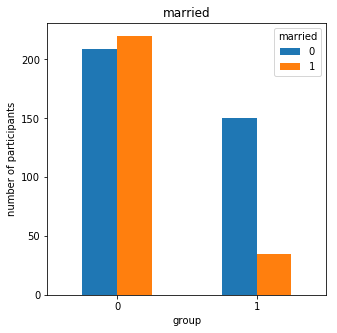


Control group
count    429.00
mean       0.51
std        0.50
min        0.00
25%        0.00
50%        1.00
75%        1.00
max        1.00
Name: married, dtype: float64

Treatment group
count    185.00
mean       0.19
std        0.39
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: married, dtype: float64

Chi-square test
p-value:  0.0
test statistic:  54.4




In [45]:
analyse_categoric(lalonde_data, 'married')

                                   nodegree


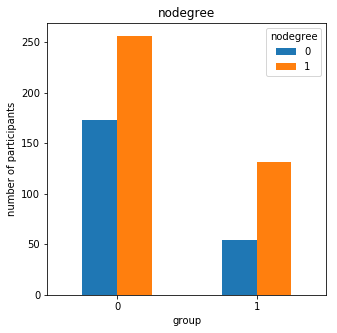


Control group
count    429.00
mean       0.60
std        0.49
min        0.00
25%        0.00
50%        1.00
75%        1.00
max        1.00
Name: nodegree, dtype: float64

Treatment group
count    185.00
mean       0.71
std        0.46
min        0.00
25%        0.00
50%        1.00
75%        1.00
max        1.00
Name: nodegree, dtype: float64

Chi-square test
p-value:  0.0113
test statistic:  6.4




In [46]:
analyse_categoric(lalonde_data, 'nodegree')

                                  race


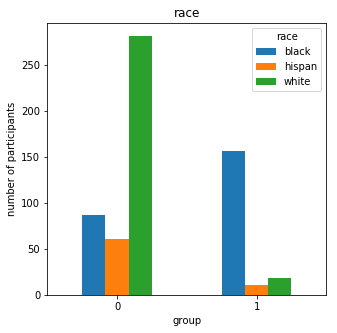



Chi-square test
p-value:  0.0
test statistic:  224.1


In [47]:
analyse_race(lalonde_data)

**Conclusions:**

## 3. A propensity score model

In [18]:
logistic = linear_model.LogisticRegression()

logistic = logistic.fit(lalonde_data.drop(lalonde_data.columns[[0, 1, -1]], axis=1), lalonde_data.treat)
propensity_scores = logistic.predict_proba(lalonde_data.drop(lalonde_data.columns[[0, 1, -1]], axis=1))

In [19]:
print(logistic.classes_)
print(propensity_scores[:5])

[0 1]
[[ 0.55664958  0.44335042]
 [ 0.85534047  0.14465953]
 [ 0.27764537  0.72235463]
 [ 0.33584948  0.66415052]
 [ 0.30171439  0.69828561]]


In [20]:
lalonde_data['propensity'] = propensity_scores[:, 1]

## 4. Balancing the dataset via matching

1:1, without replacement
optimal matching

In [48]:
graph_data = pd.merge(lalonde_data.reset_index()[lalonde_data.treat == 1].assign(key=0), lalonde_data.reset_index()[lalonde_data.treat == 0].assign(key=0), on='key').drop('key', axis=1)
graph_data['weight'] = 1 - np.abs(graph_data['propensity_x'] - graph_data['propensity_y'])
G = nx.Graph()
G.add_weighted_edges_from(zip(graph_data.index_x, graph_data.index_y, graph_data.weight))
matching = nx.max_weight_matching(G)

In [49]:
len(matching) == 2 * len(lalonde_data[lalonde_data.treat == 1])

True

In [50]:
lalonde_data_balanced = lalonde_data.iloc[list(matching.keys())]
lalonde_data_balanced.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


## Perform same analysis as in 1 and 2 

                                   re78


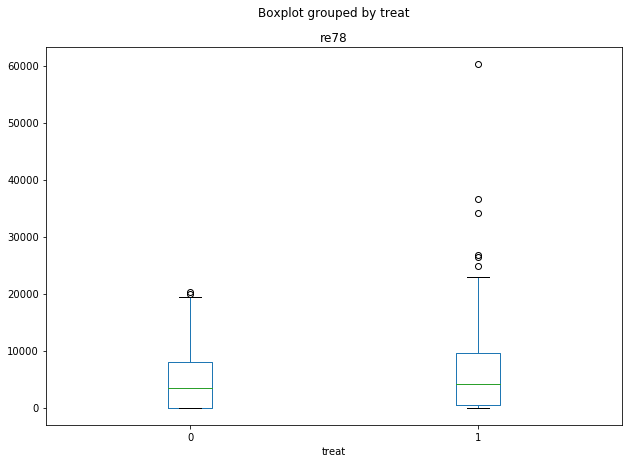

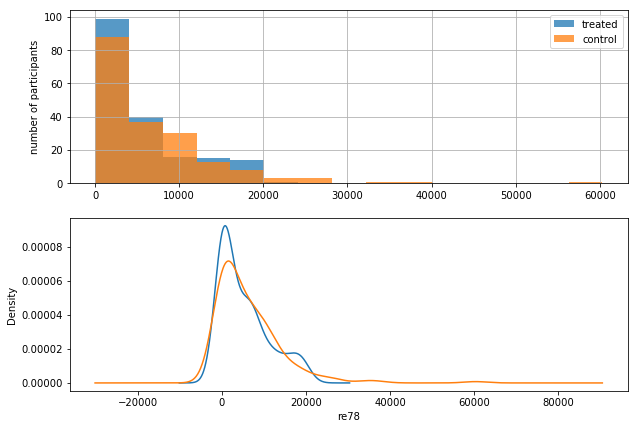

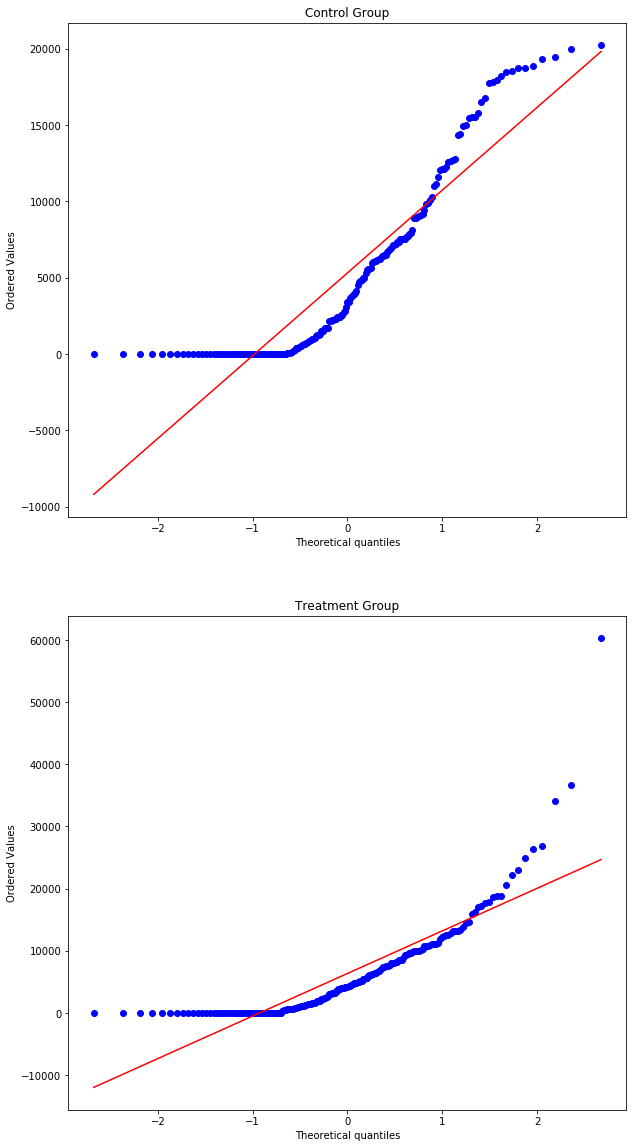


Control group
count      185.00
mean      5312.47
std       5842.88
min          0.00
25%          0.00
50%       3392.86
75%       7933.91
max      20243.38
Name: re78, dtype: float64

Treatment group
count      185.00
mean      6349.14
std       7867.40
min          0.00
25%        485.23
50%       4232.31
75%       9643.00
max      60307.93
Name: re78, dtype: float64

Mann-Whitney-U test:
p-value:  0.1754
test statistic:  16159.5




In [51]:
analyse_numeric(lalonde_data_balanced, 're78')

                                   age


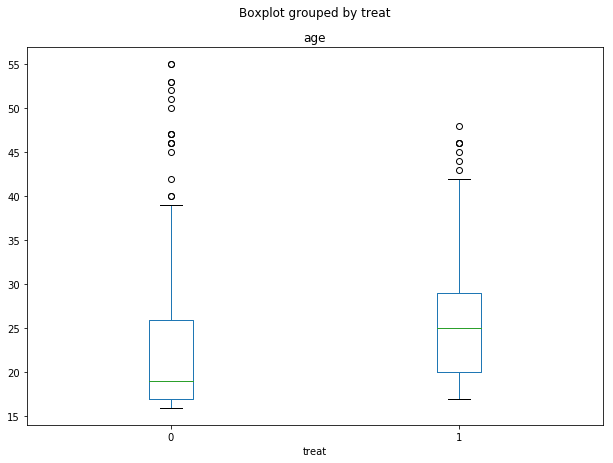

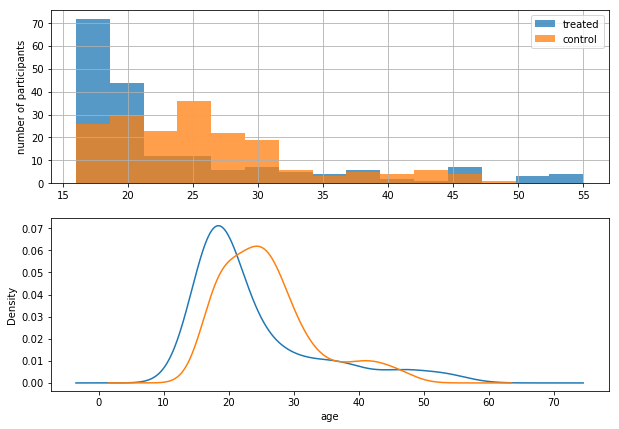

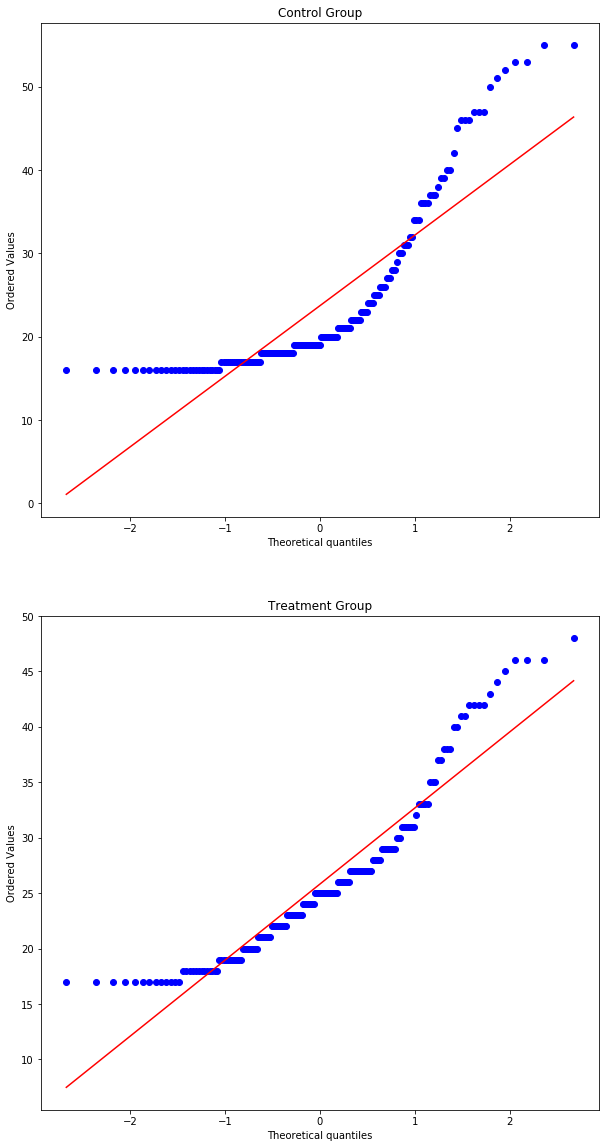


Control group
count    185.00
mean      23.71
std        9.64
min       16.00
25%       17.00
50%       19.00
75%       26.00
max       55.00
Name: age, dtype: float64

Treatment group
count    185.00
mean      25.82
std        7.16
min       17.00
25%       20.00
50%       25.00
75%       29.00
max       48.00
Name: age, dtype: float64

Mann-Whitney-U test:
p-value:  0.0
test statistic:  11661.5




In [52]:
analyse_numeric(lalonde_data_balanced, 'age')

                                   educ


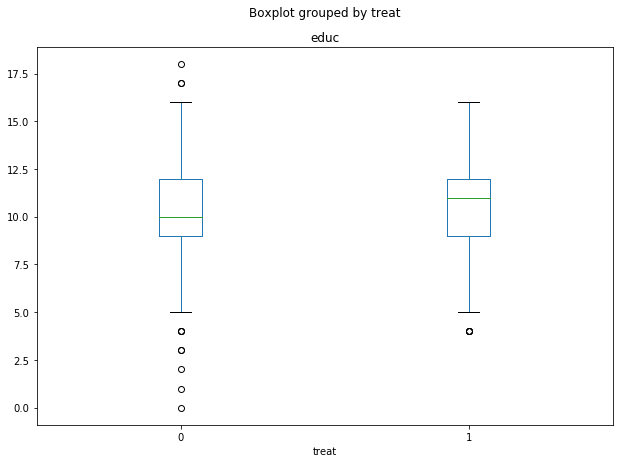

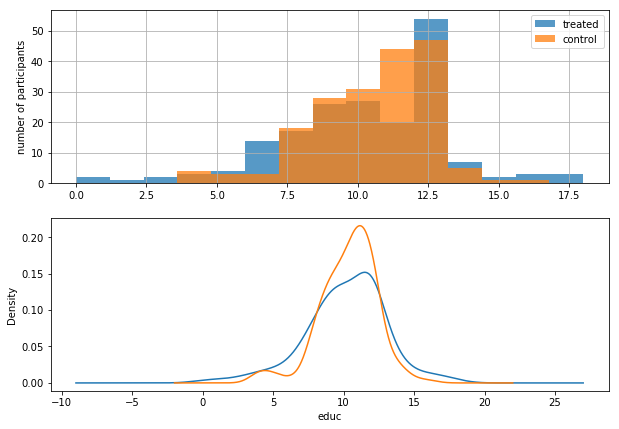

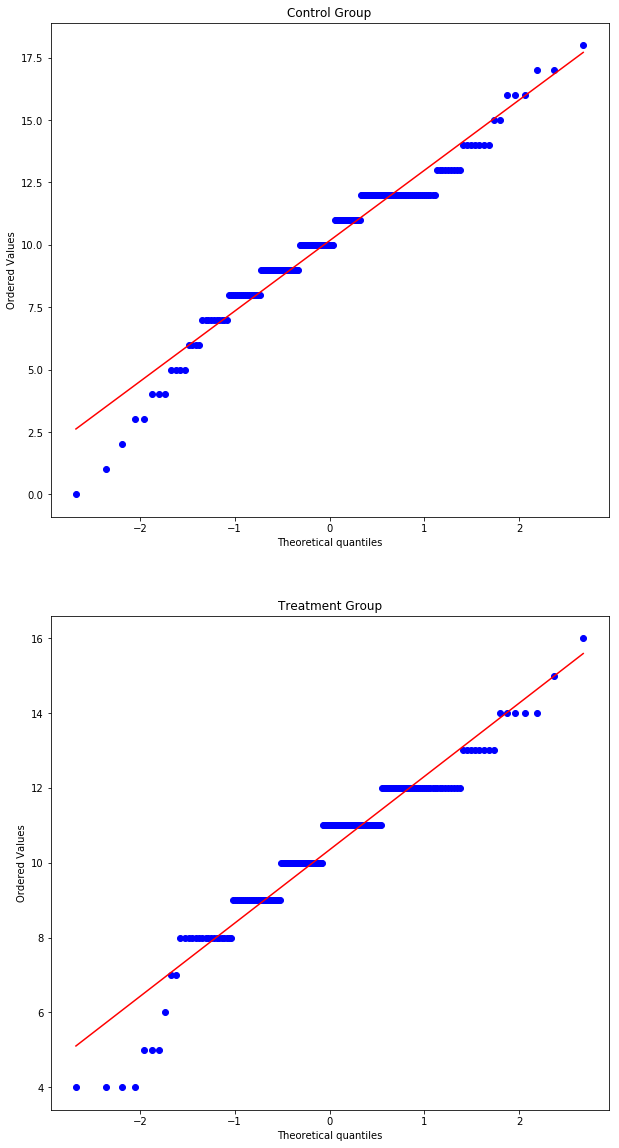


Control group
count    185.00
mean      10.16
std        2.86
min        0.00
25%        9.00
50%       10.00
75%       12.00
max       18.00
Name: educ, dtype: float64

Treatment group
count    185.00
mean      10.35
std        2.01
min        4.00
25%        9.00
50%       11.00
75%       12.00
max       16.00
Name: educ, dtype: float64

Mann-Whitney-U test:
p-value:  0.3611
test statistic:  16751.0




In [53]:
analyse_numeric(lalonde_data_balanced, 'educ')

                                   re74


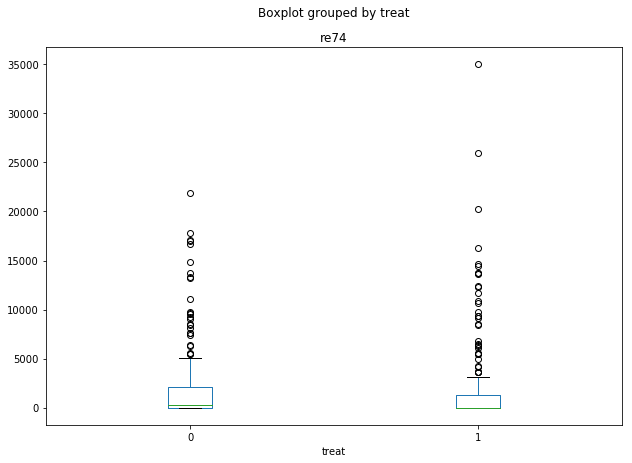

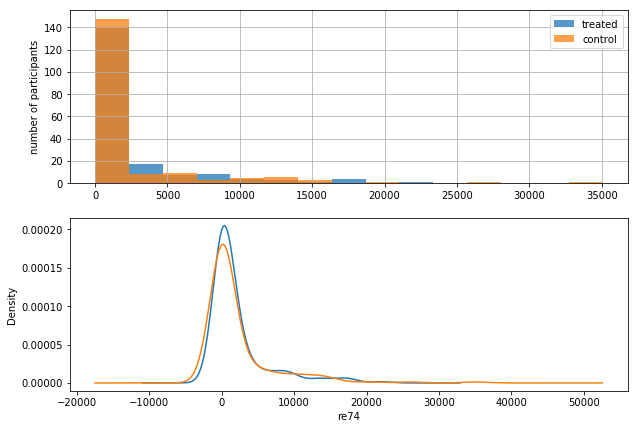

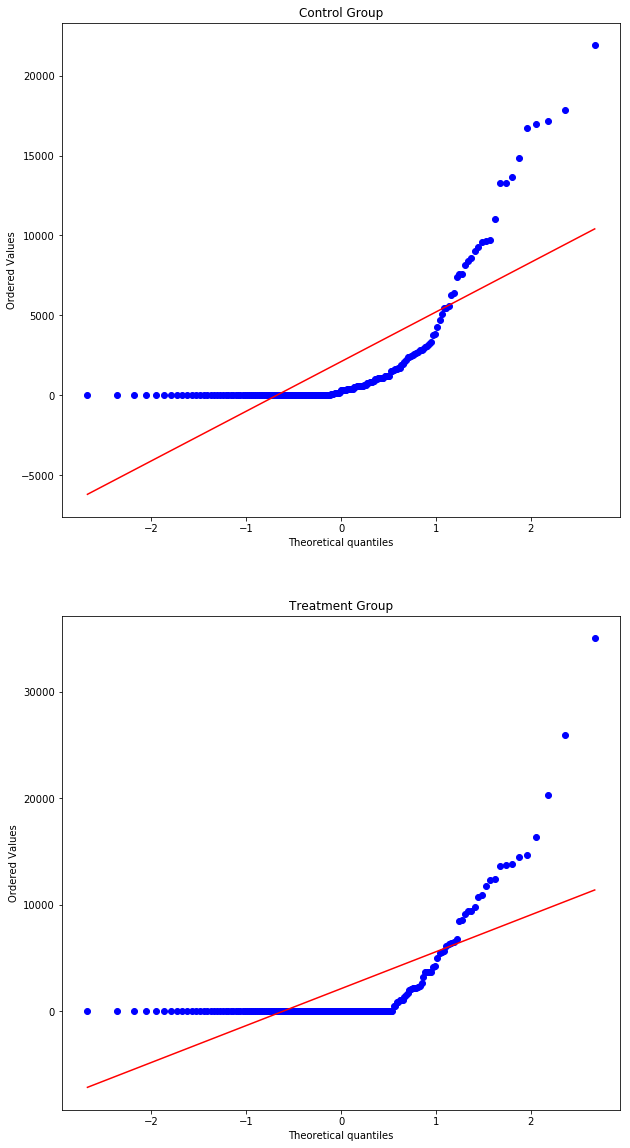


Control group
count      185.00
mean      2095.89
std       4029.20
min          0.00
25%          0.00
50%        289.97
75%       2068.99
max      21918.32
Name: re74, dtype: float64

Treatment group
count      185.00
mean      2095.57
std       4886.62
min          0.00
25%          0.00
50%          0.00
75%       1291.47
max      35040.07
Name: re74, dtype: float64

Mann-Whitney-U test:
p-value:  0.0002
test statistic:  13873.0




In [54]:
analyse_numeric(lalonde_data_balanced, 're74')

                                   re75


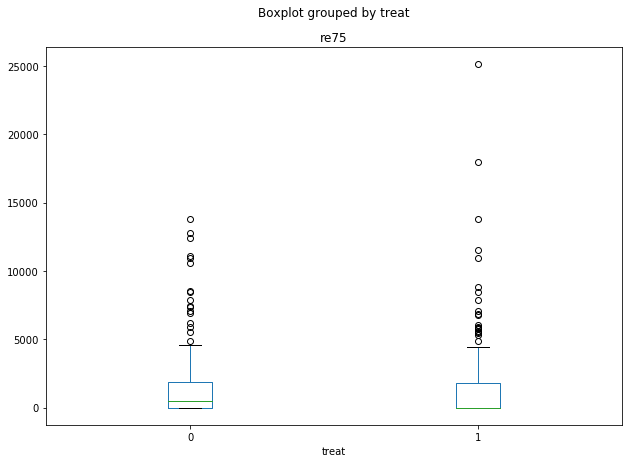

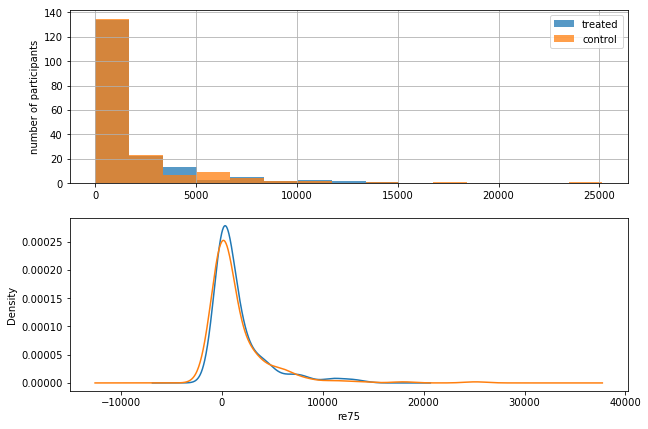

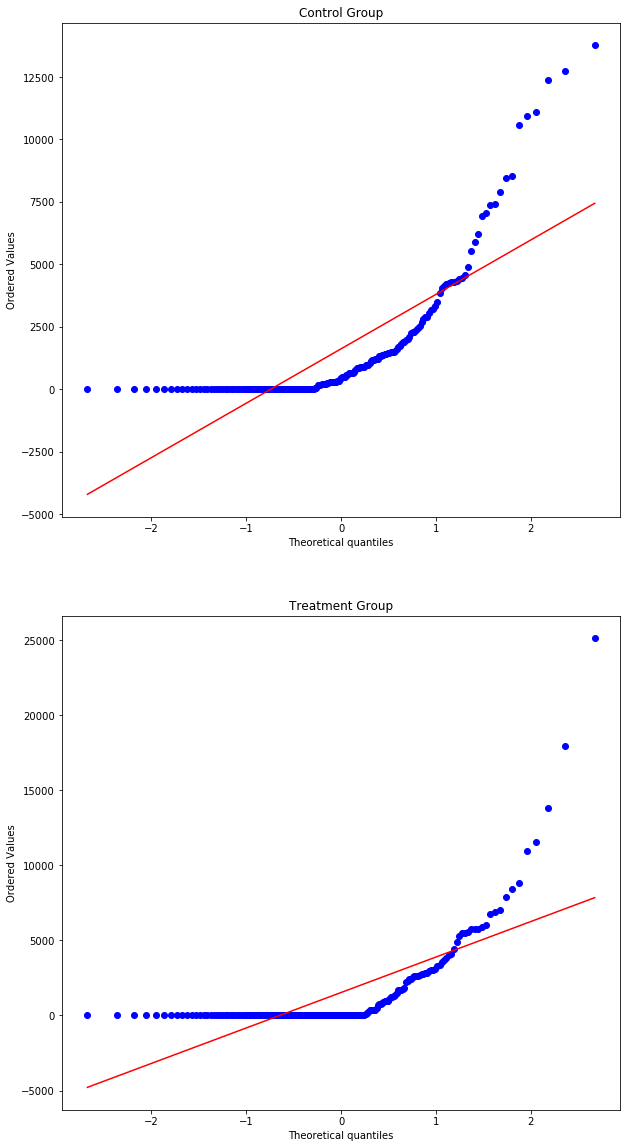


Control group
count      185.00
mean      1615.31
std       2674.75
min          0.00
25%          0.00
50%        451.16
75%       1890.58
max      13776.53
Name: re75, dtype: float64

Treatment group
count      185.00
mean      1532.06
std       3219.25
min          0.00
25%          0.00
50%          0.00
75%       1817.28
max      25142.24
Name: re75, dtype: float64

Mann-Whitney-U test:
p-value:  0.0034
test statistic:  14504.0




In [55]:
analyse_numeric(lalonde_data_balanced, 're75')

                                   married


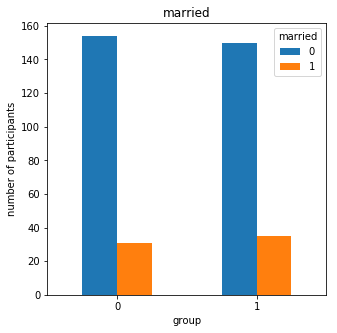


Control group
count    185.00
mean       0.17
std        0.37
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: married, dtype: float64

Treatment group
count    185.00
mean       0.19
std        0.39
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: married, dtype: float64

Chi-square test
p-value:  0.6837
test statistic:  0.2




In [56]:
analyse_categoric(lalonde_data_balanced, 'married')

                                   nodegree


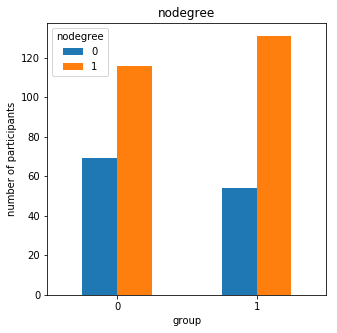


Control group
count    185.00
mean       0.63
std        0.48
min        0.00
25%        0.00
50%        1.00
75%        1.00
max        1.00
Name: nodegree, dtype: float64

Treatment group
count    185.00
mean       0.71
std        0.46
min        0.00
25%        0.00
50%        1.00
75%        1.00
max        1.00
Name: nodegree, dtype: float64

Chi-square test
p-value:  0.1223
test statistic:  2.4




In [57]:
analyse_categoric(lalonde_data_balanced, 'nodegree')

                                  race


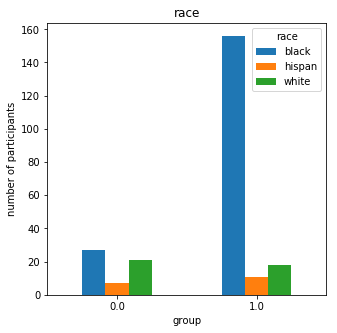



Chi-square test
p-value:  0.0
test statistic:  59.0


In [58]:
analyse_race(lalonde_data_balanced)

In [59]:
#todo it somehow would make more sense for race ro see ratios... -> relative bezogen auf treatment gruppe

not satisfied: re75, re74, age, race(?)

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching? Would you say your dataset is sufficiently balanced? If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

## 5. Balancing the groups further

identify "the problematic feature": if different in this feature: add very high penalty to weight, oder: direkt in join auf equality filtern :P

problenatic features: age, race

Further balance for race:

In [60]:
graph_data = pd.merge(lalonde_data.reset_index()[lalonde_data.treat == 1], lalonde_data.reset_index()[lalonde_data.treat == 0], on=['black', 'hispan'])
#print(graph_data.head())
graph_data['weight'] = 1 - np.abs(graph_data['propensity_x'] - graph_data['propensity_y'])
G = nx.Graph()
G.add_weighted_edges_from(zip(graph_data.index_x, graph_data.index_y, graph_data.weight))
matching = nx.max_weight_matching(G)

In [61]:
lalonde_data_balanced = lalonde_data.iloc[list(matching.keys())]
lalonde_data_balanced.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


### Analysis

                                   re78


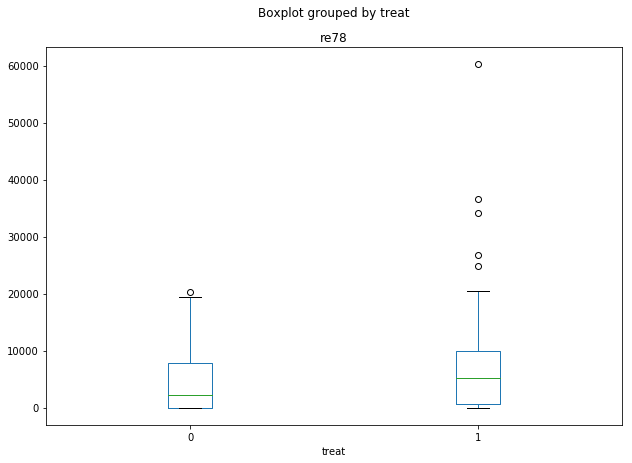

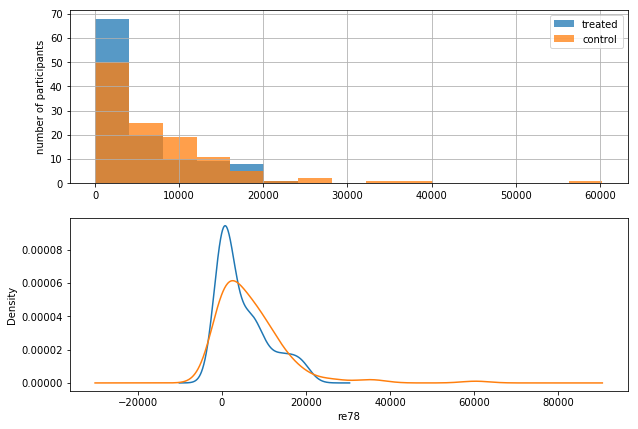

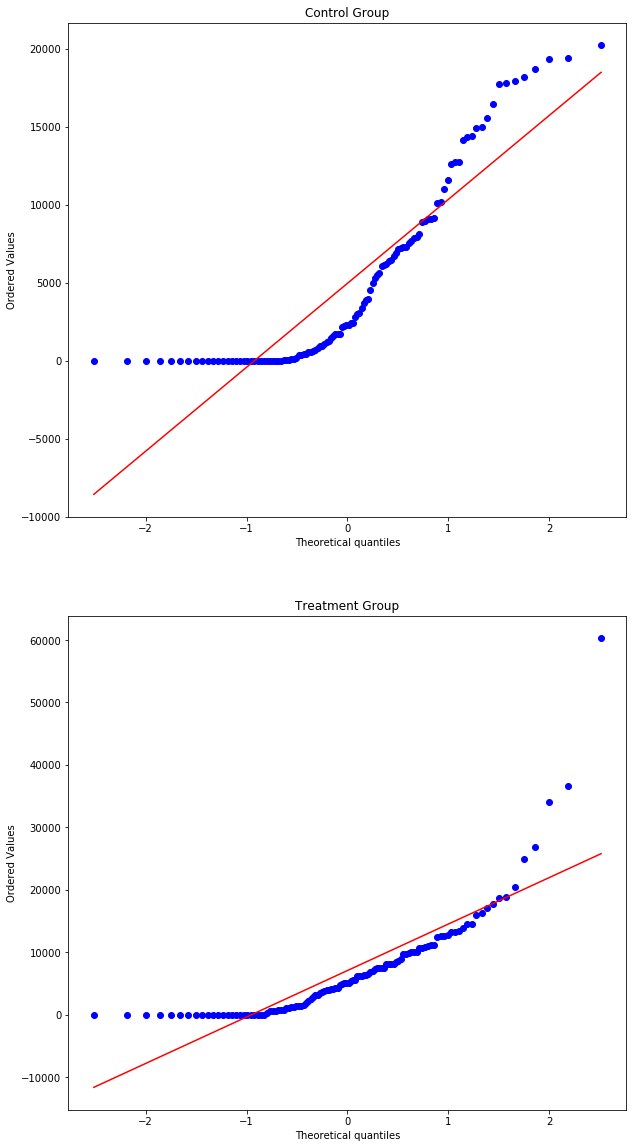


Control group
count      116.00
mean      4968.64
std       5855.64
min          0.00
25%          0.00
50%       2283.09
75%       7866.31
max      20243.38
Name: re78, dtype: float64

Treatment group
count      116.00
mean      7070.71
std       8607.70
min          0.00
25%        672.49
50%       5130.76
75%      10011.05
max      60307.93
Name: re78, dtype: float64

Mann-Whitney-U test:
p-value:  0.0249
test statistic:  5731.0




In [62]:
analyse_numeric(lalonde_data_balanced, 're78')

                                   age


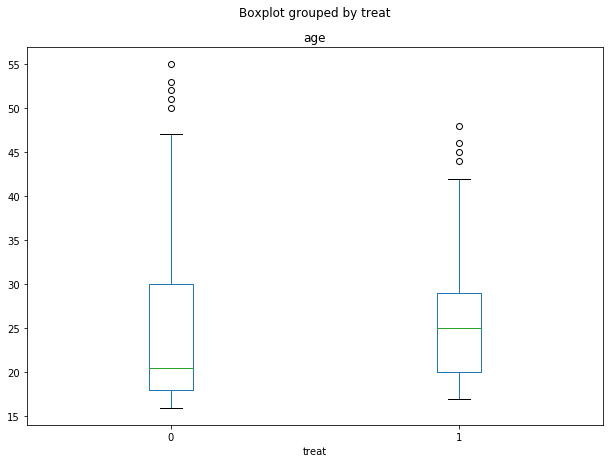

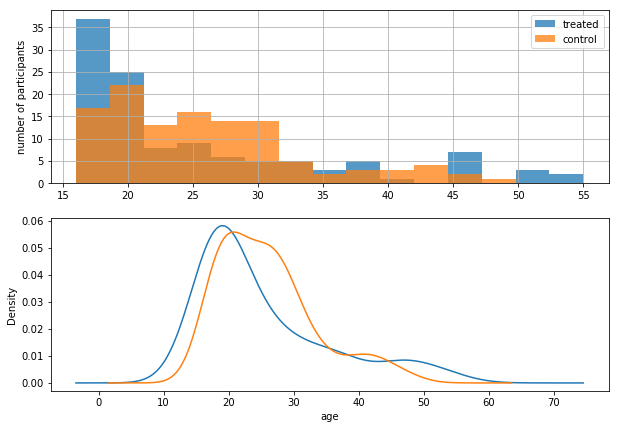

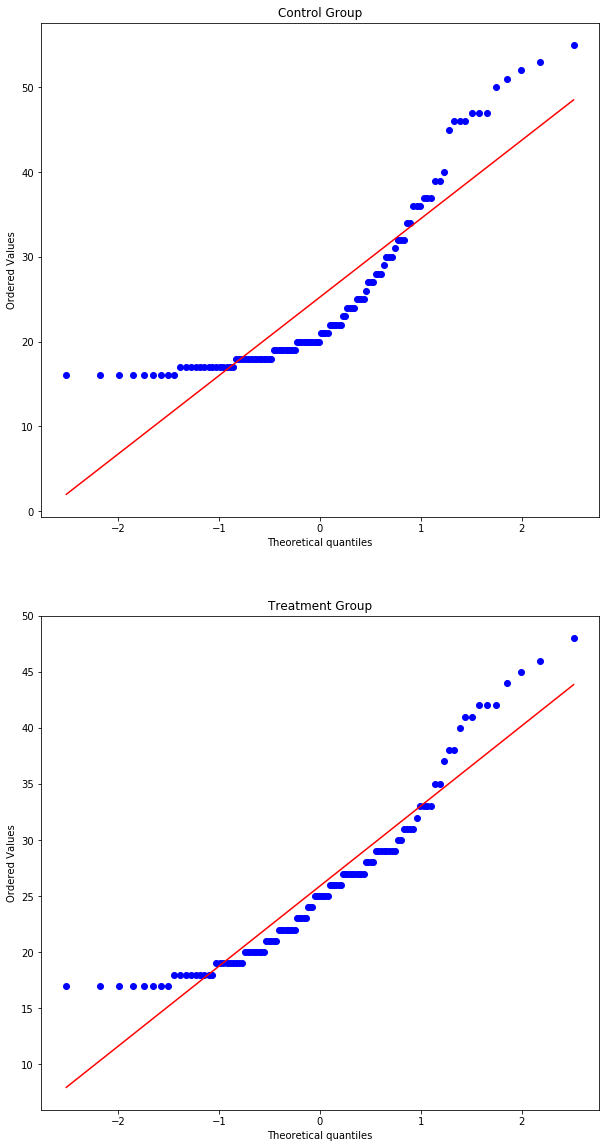


Control group
count    116.00
mean      25.25
std       10.15
min       16.00
25%       18.00
50%       20.50
75%       30.00
max       55.00
Name: age, dtype: float64

Treatment group
count    116.00
mean      25.90
std        7.39
min       17.00
25%       20.00
50%       25.00
75%       29.00
max       48.00
Name: age, dtype: float64

Mann-Whitney-U test:
p-value:  0.0088
test statistic:  5515.5




In [63]:
analyse_numeric(lalonde_data_balanced, 'age')

                                   educ


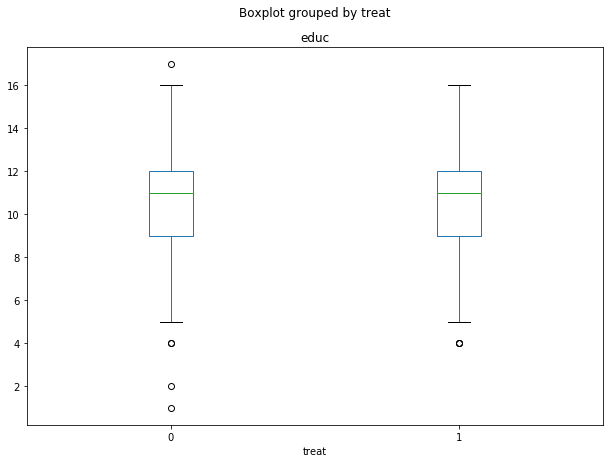

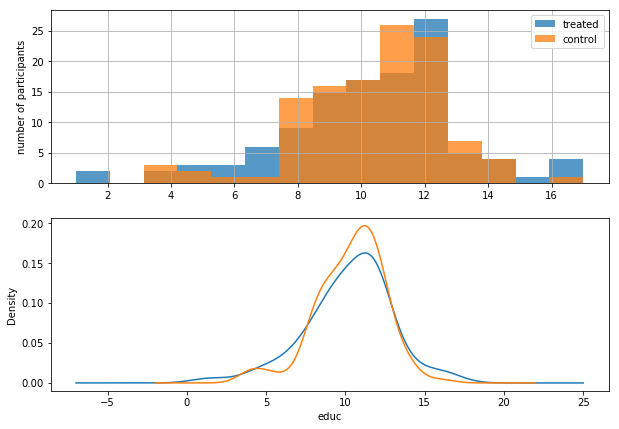

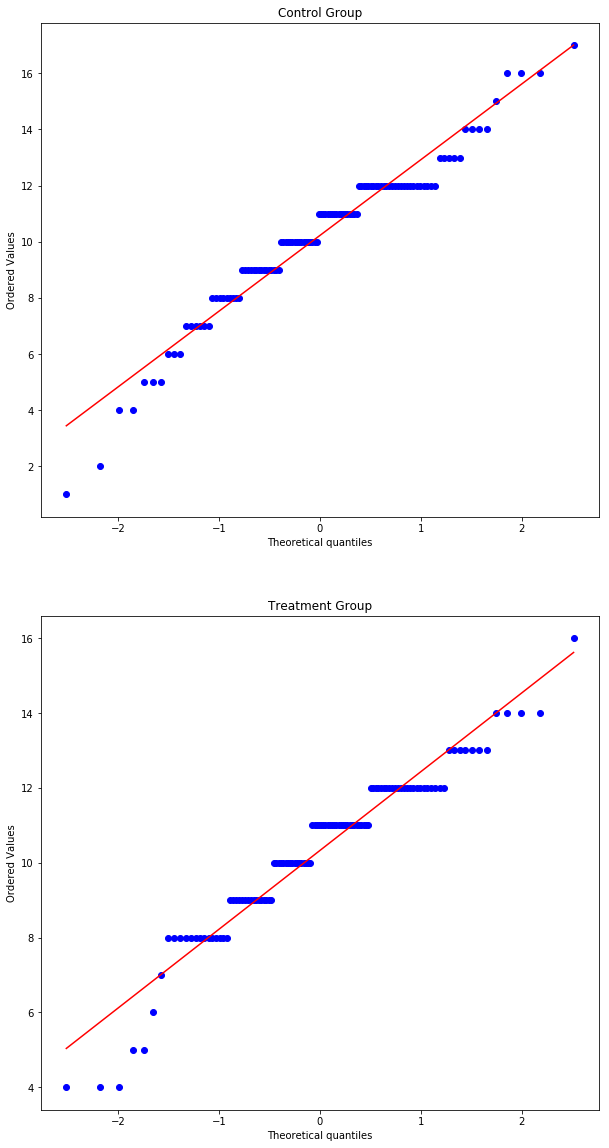


Control group
count    116.00
mean      10.22
std        2.73
min        1.00
25%        9.00
50%       11.00
75%       12.00
max       17.00
Name: educ, dtype: float64

Treatment group
count    116.00
mean      10.33
std        2.14
min        4.00
25%        9.00
50%       11.00
75%       12.00
max       16.00
Name: educ, dtype: float64

Mann-Whitney-U test:
p-value:  0.4484
test statistic:  6662.0




In [64]:
analyse_numeric(lalonde_data_balanced, 'educ')

                                   re74


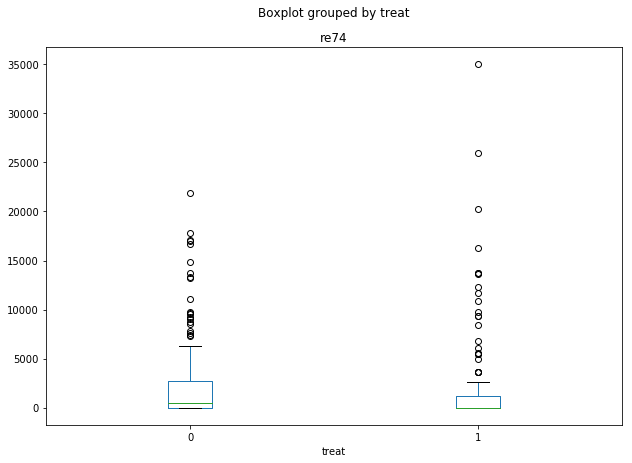

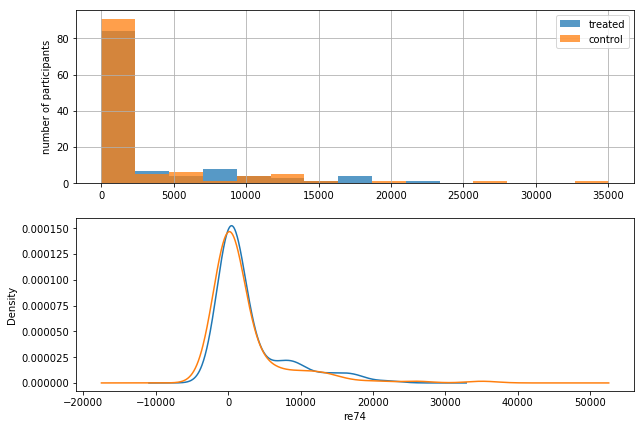

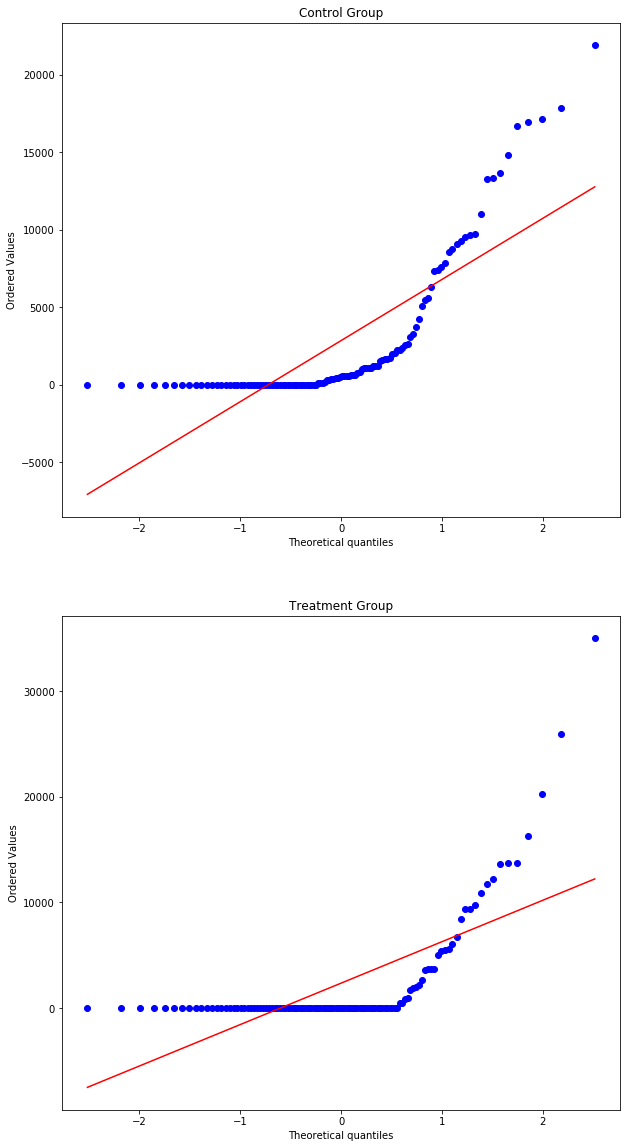


Control group
count      116.00
mean      2846.65
std       4818.60
min          0.00
25%          0.00
50%        515.29
75%       2760.12
max      21918.32
Name: re74, dtype: float64

Treatment group
count      116.00
mean      2351.18
std       5535.98
min          0.00
25%          0.00
50%          0.00
75%       1171.08
max      35040.07
Name: re74, dtype: float64

Mann-Whitney-U test:
p-value:  0.0001
test statistic:  5039.5




In [65]:
analyse_numeric(lalonde_data_balanced, 're74')

                                   re75


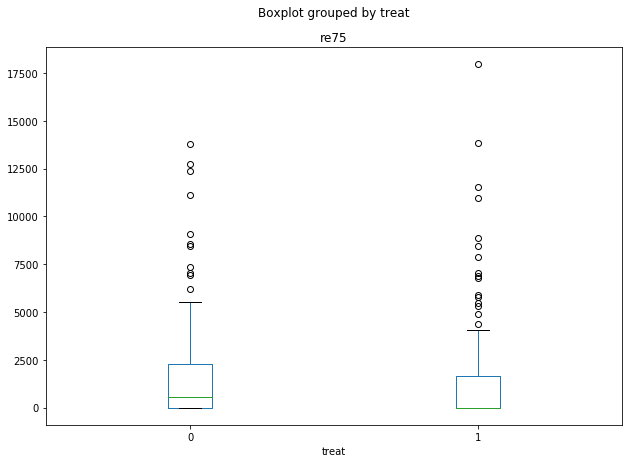

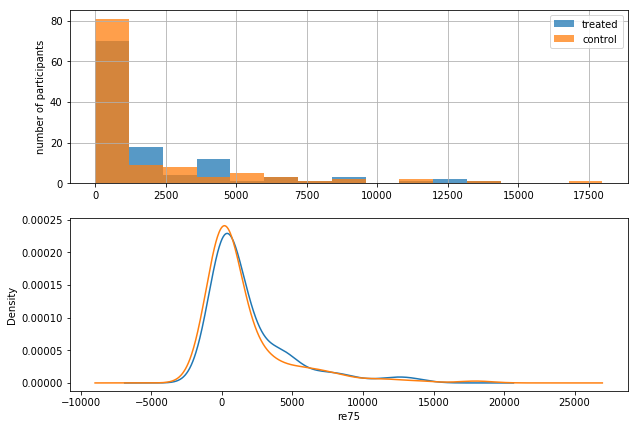

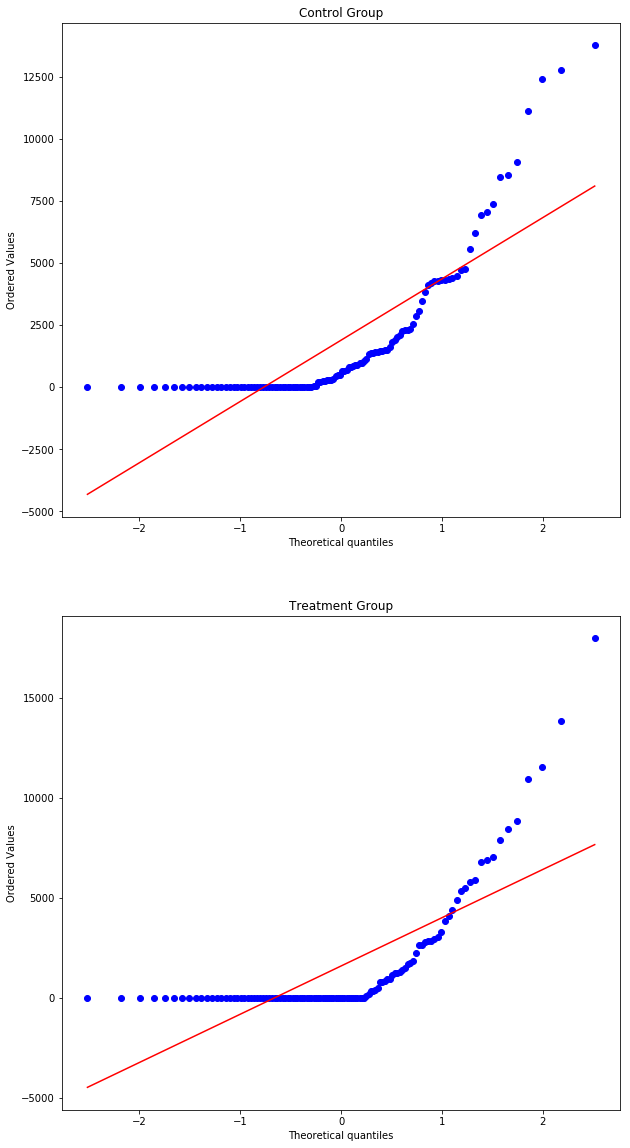


Control group
count      116.00
mean      1882.17
std       2943.71
min          0.00
25%          0.00
50%        555.00
75%       2302.80
max      13776.53
Name: re75, dtype: float64

Treatment group
count      116.00
mean      1587.20
std       3128.63
min          0.00
25%          0.00
50%          0.00
75%       1677.87
max      17976.15
Name: re75, dtype: float64

Mann-Whitney-U test:
p-value:  0.0082
test statistic:  5575.5




In [66]:
analyse_numeric(lalonde_data_balanced, 're75')

                                   married


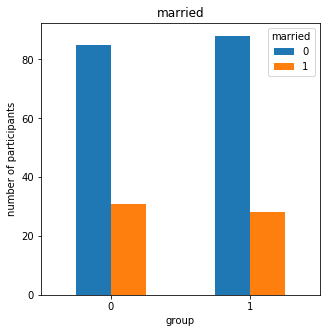


Control group
count    116.00
mean       0.27
std        0.44
min        0.00
25%        0.00
50%        0.00
75%        1.00
max        1.00
Name: married, dtype: float64

Treatment group
count    116.00
mean       0.24
std        0.43
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: married, dtype: float64

Chi-square test
p-value:  0.763
test statistic:  0.1




In [67]:
analyse_categoric(lalonde_data_balanced, 'married')

                                   nodegree


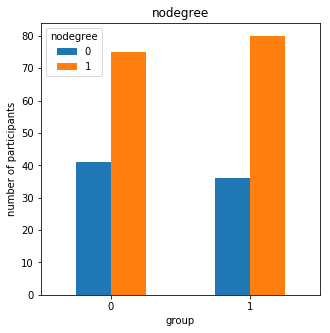


Control group
count    116.00
mean       0.65
std        0.48
min        0.00
25%        0.00
50%        1.00
75%        1.00
max        1.00
Name: nodegree, dtype: float64

Treatment group
count    116.00
mean       0.69
std        0.46
min        0.00
25%        0.00
50%        1.00
75%        1.00
max        1.00
Name: nodegree, dtype: float64

Chi-square test
p-value:  0.5771
test statistic:  0.3




In [68]:
analyse_categoric(lalonde_data_balanced, 'nodegree')

                                  race


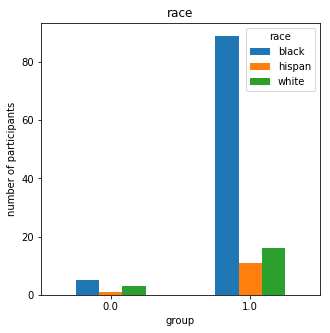



Chi-square test
p-value:  1.0
test statistic:  0.0


In [69]:
analyse_race(lalonde_data_balanced)

## 6. A less naive analysis

Remark that sensitivity analysis would be good!!

In [70]:
len(lalonde_data_balanced)

232

Compare the outcomes (re78) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5. What do you conclude about the effectiveness of the job training program